In [2]:
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import cv2
import pandas as pd
import dlib 
import re
#Additional
import datetime as dt
dataset_path = r'H:\FYP_Data\s1'
input_files = [filename for filename in os.listdir(dataset_path) if filename.endswith(".npy") and re.match(r".*input\d+\.npy", filename)]
label_files = []
# Check if each input file has a corresponding label file
isValid = True
for input_file in input_files:
    label_filename = input_file.replace("input", "label")
    if label_filename not in os.listdir(dataset_path):
        isValid = False
        print(f"Label file {label_filename} is missing for input file {input_file}!")
    else:
        label_files.append(label_filename)
if isValid == True:
    print(f"{len(input_files)} input chunks and {len(label_files)} label chunks detected.")
    # Extract SizeW value
    match_size_w = re.search(r"SizeW(\d+)", dataset_path)
    size_w = match_size_w.group(1) if match_size_w else None

    # Extract SizeH value
    match_size_h = re.search(r"SizeH(\d+)", dataset_path)
    size_h = match_size_h.group(1) if match_size_h else None

    # Extract ClipLength value
    match_clip_length = re.search(r"ClipLength(\d+)", dataset_path)
    clip_length = match_clip_length.group(1) if match_clip_length else None

    print(f"Preprocessed data has a width of {size_w}, height of {size_h}, and a clip length of {clip_length}.")
else:
    print("Preprocessed dataset is invalid! Please delete the preprocessed dataset folder and try to preprocess it again.")


1 input chunks and 1 label chunks detected.
Preprocessed data has a width of None, height of None, and a clip length of None.


In [3]:
# print(np.shape(input_files))
# print(np.shape(label_files))
print(input_files)
print(label_files)

['vid_s1_input01.npy']
['vid_s1_label01.npy']


In [4]:
label_file = label_files[0]
label_data = np.load(os.path.join(dataset_path, label_file))
# print(label_data)
input_file = input_files[0]
input_data = np.load(os.path.join(dataset_path, input_file))
print(input_data.shape)

(6325, 1024, 1024, 3)


set global variables

In [5]:
idx_frame_start = 0
idx_frame_end = len(input_data) - 1
fps = 35
n_segment = 6
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [6]:
detector = dlib.get_frontal_face_detector()

In [7]:
## loop for all image
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skin_pixel = 0


In [8]:
import skin_detector

In [9]:
# mean_rgb = None
# i_cnt = 0
# f_cnt = 0
while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end ):
    frame = input_data[i_cnt]
    h, w, _ = frame.shape


    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, Width: {w}")


    # -- Detect face on first frame
    if f_cnt == 0:
        rect = detector(frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()

        width = abs(right - left)
        height = abs(bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        # face_left = left
        face_top = int(top - (top_expand_ratio/2 * width))
        # face_top = top
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]
    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, Width: {w}")


    if mask is None:
        mask = skin_detector.process(face)
        n_skin_pixel = np.sum(mask)

    # print(f"Mask \n {mask}")
    # print(f"Number of skin pixels: {n_skin_pixel}")

    masked_face = cv2.bitwise_and(face, face, mask=mask)
    # frame_toshow = cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # count mean of R G B
    mean_r = np.sum(masked_face[:,:,2]) / n_skin_pixel
    mean_g = np.sum(masked_face[:,:,1]) / n_skin_pixel
    mean_b = np.sum(masked_face[:,:,0]) / n_skin_pixel

    if f_cnt == 0:
        mean_rgb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb, np.array([mean_r, mean_g, mean_b])))
        

    f_cnt += 1
    i_cnt += 1


    # break
print(f_cnt)

6325


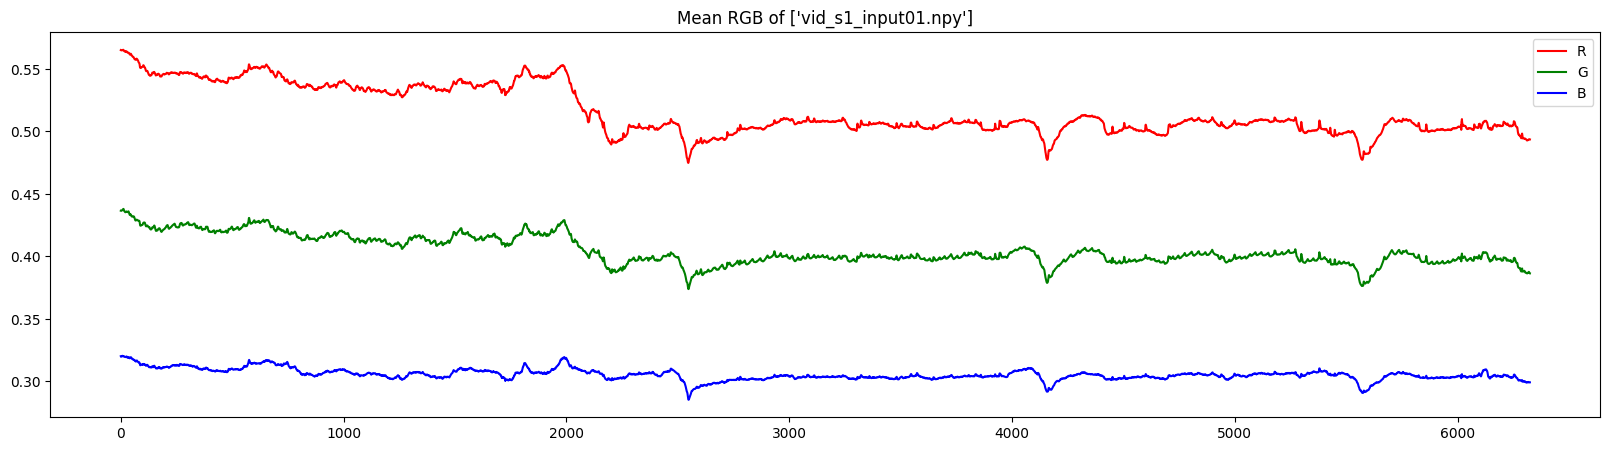

In [10]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label="R", color="red")
plt.plot(mean_rgb[:,1], label="G", color="green")
plt.plot(mean_rgb[:,2], label="B", color="blue")
plt.legend()
plt.title(f"Mean RGB of {input_files}")
plt.show()


**POS**

In [11]:
l = int(fps * 1.6)
print(f"Window Length: {l}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window Length: 56
rPPG_signals shape: (6325,)


In [12]:
%matplotlib inline
for t in range(0, mean_rgb.shape[0]-l):
    
    ## step 1 : create C Matrix
    C = mean_rgb[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print(C)

    ## step 2 : Temperal normalization
    # =====================

    mean_color = np.mean(C, axis=1)
    # print(f"shape of mean_color: {mean_color.shape}")
    # print(f"Mean color\n {mean_color}")

    diag_mean_color = np.diag(mean_color)
    # print(f"shape of diag_mean_color: {diag_mean_color.shape}")
    # print(f"diag_mean_color\n {diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"shape of diag_mean_color_inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inverse\n {diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Shape of Cn: {Cn.shape}")

    ## step 3 : From 3D TO 2D
    # =====================
    projection_matrix = np.array([[0,1,-1],[-2,1,1]])

    S = np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ## step 4 : From 2D TO 1D (P)
    # ================================

    std = np.array( [1, np.std(S[0,:]) / np.std(S[1,:])] )
    # print(f"shape of std: {std.shape}")
    # print(f"std \n {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## step 5: Overlapping For All Signal with Normalization
    # ===================================================
    rPPG_signals[t:t+l-1] = rPPG_signals[t:t+l-1] + (P - np.mean(P)) / np.std(P)

    # plt.figure(figsize=(20,5))
    # plt.plot(rPPG_signals)
    # plt.show()

    # break

Shape of P: (6325,)


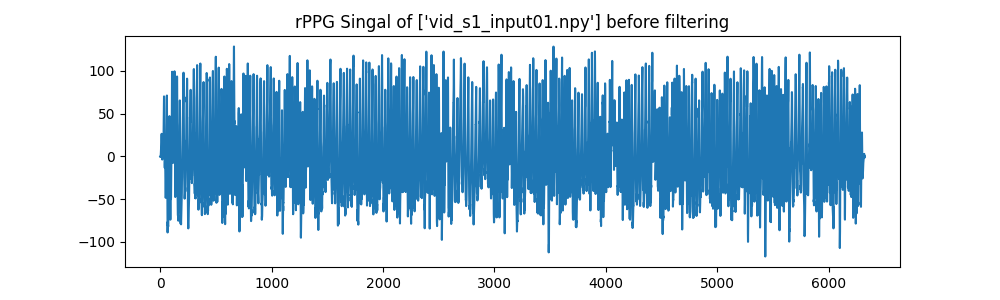

In [13]:
## step 6. Post-Prossing
%matplotlib widget

print(f"Shape of P: {rPPG_signals.shape}")
plt.figure(figsize=(10,3))
plt.plot(rPPG_signals)
plt.title(f'rPPG Singal of {input_files} before filtering')
plt.show()

Filtering


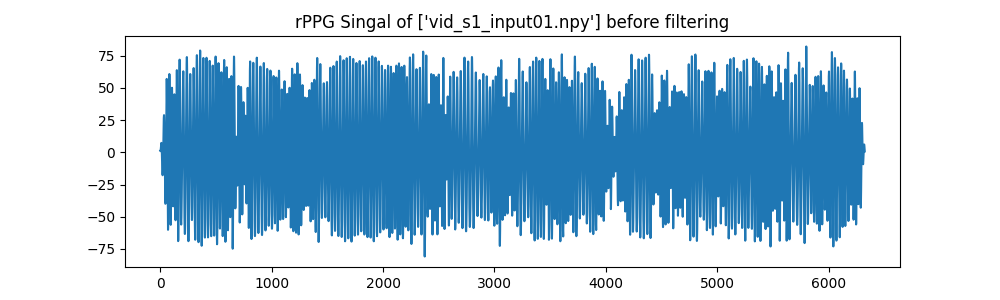

In [45]:
import scipy.signal as signal
lowcut = 0.8
highcut = 2

b, a = signal.butter(2, [lowcut, highcut], btype="bandpass", fs = fps)
rPPG_filtered = signal.filtfilt(b,a,rPPG_signals)

## Check the result
plt.figure(figsize=(10,3))
plt.plot(rPPG_filtered)
plt.title(f'rPPG Singal of {input_files} before filtering')
plt.show()

Compare With Ground Truth

(11519, 1)


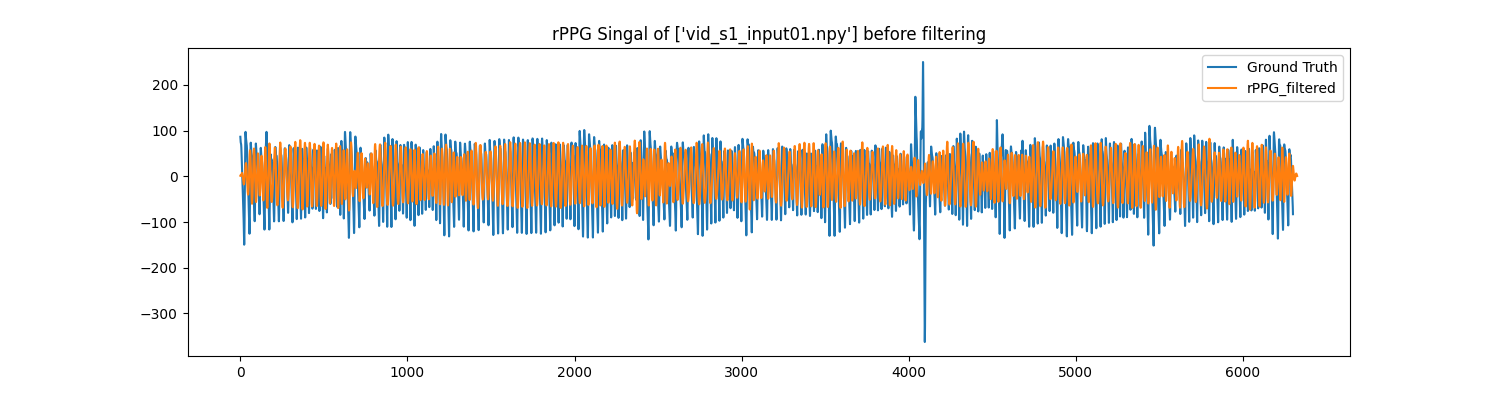

In [15]:
print(label_data.shape)
gt_sig = (label_data - np.mean(label_data) / np.std(label_data))

## Plot 
#plt.plot(arg1: x_data, arg2: y_data)

plt.figure(figsize=(15,4))
gt_time = np.arange(len(gt_sig))
scale_ratio = 35 / 64
gt_rescaled_time = gt_time * scale_ratio
plt.plot(gt_rescaled_time, gt_sig, label = "Ground Truth")

plt.plot(rPPG_filtered, label = "rPPG_filtered")
plt.legend()
plt.title(f'rPPG Singal of {input_files} before filtering')
plt.show()
# index scale = index * 35 / 64 = 0.546875 frome index = P , 1.82857 frame 


In [16]:
print(gt_sig.shape)

(11519, 1)


**Count BPM**

In [17]:
gt_sig = np.squeeze(gt_sig)


In [18]:
print(gt_sig.shape)


(11519,)


(11519,)
19.2


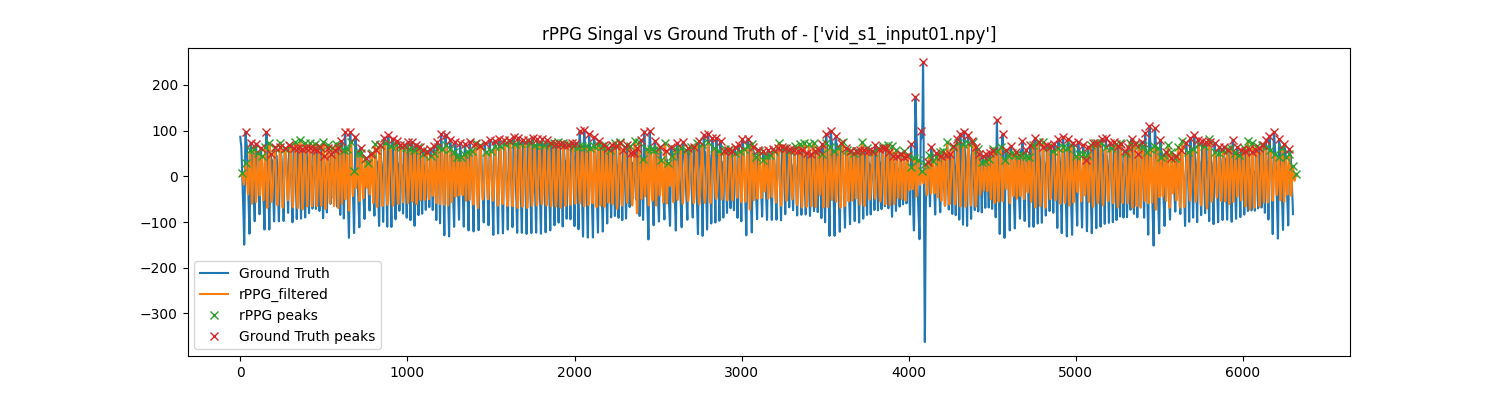

GT Peaks = 246 | rPPG Peaks = 246


In [19]:
from scipy.signal import find_peaks
print(gt_sig.shape)
gt_sample_rate = 64
max_bmp_per_second = 200/60
min_dis =  (gt_sample_rate/max_bmp_per_second)
print(min_dis)
gt_peaks, _ = find_peaks(gt_sig, distance= min_dis)
rPPG_peaks, _ = find_peaks(rPPG_filtered)
## Plot 
plt.figure(figsize=(15,4))
gt_time = np.arange(len(gt_sig))
scale_ratio = 35 / 64
gt_rescaled_time = gt_time * scale_ratio
plt.plot(gt_rescaled_time, gt_sig, label = "Ground Truth")
plt.plot(rPPG_filtered, label = "rPPG_filtered")
plt.plot(rPPG_peaks, rPPG_filtered[rPPG_peaks], "x",label = "rPPG peaks")
plt.plot(gt_rescaled_time[gt_peaks], gt_sig[gt_peaks], "x",label = "Ground Truth peaks")
# plt.scatter(rPPG_peaks[0], rPPG_filtered[rPPG_peaks[0
plt.legend()
plt.title(f'rPPG Singal vs Ground Truth of - {input_files}')
plt.show()

print(f"GT Peaks = {len(gt_peaks)} | rPPG Peaks = {len(rPPG_peaks)}")

power spectrum 

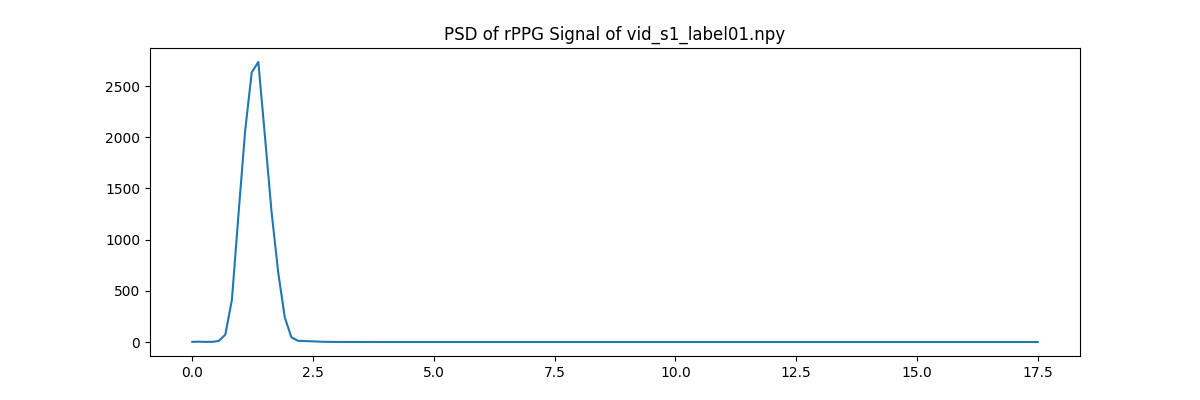

Max Frequency in rPPG PSD: 1.3671875 Hz
rPPG Heart Rate: 82.03125 BPM


In [44]:
from scipy.signal import welch
seg_len = (2 * rPPG_filtered.shape[0])//5 + 1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=None, window="flattop" , scaling="density",noverlap=None, average="mean") 
# freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window="flattop") 

plt.figure(figsize=(12,4))
plt.plot(freq_rPPG, psd_rPPG)
plt.title(f"PSD of rPPG Signal of {label_filename}")
plt.show()

max_freq_rPPG = freq_rPPG[np.argmax(psd_rPPG)]
print(f"Max Frequency in rPPG PSD: {max_freq_rPPG} Hz")
rPPG_bpm = max_freq_rPPG * 60
print(f"rPPG Heart Rate: {rPPG_bpm} BPM")